In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import re
from sklearn.utils import resample
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [14]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
data = pd.read_csv("/content/gdrive/MyDrive/Twitter/train_E6oV3lV.csv")
validation = pd.read_csv("/content/gdrive/MyDrive/Twitter/test_tweets_anuFYb8.csv")
print(data.shape)
data.head()

(31962, 3)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
data = data.drop(['id'], axis=1)
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [7]:
validation = validation.drop(['id'], axis=1)
validation.head()

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone to s...
2,safe ways to heal your #acne!! #altwaystohe...
3,is the hp and the cursed child book up for res...
4,"3rd #bihday to my amazing, hilarious #nephew..."


In [8]:
print(data['tweet'].isna().sum())
print(data['label'].isna().sum())
print(validation['tweet'].isna().sum())

0
0
0


In [58]:
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(elem)))
    return df

In [10]:
def removeStopWords(df, text_field):
    for i in range(len(df)):
        words = word_tokenize(df[text_field][i])
        new = []
        for word in words:
            if word not in stopwords.words('english'):
                new.append(word)
        df[text_field][i] = ' '.join(new)
    return df

In [11]:
def lemmatization(df, text_field):
    lem = WordNetLemmatizer()
    for i in range(len(df)):
        words = word_tokenize(df[text_field][i])
        words = [lem.lemmatize(word,pos='v') for word in words]
        df[text_field][i] = ' '.join(words)
    return df

In [12]:
def preprocessing(df, text_field):
    df_clean = clean_text(df, text_field)
    df_clean = removeStopWords(df_clean, text_field)
    df_clean = lemmatization(df_clean, text_field)
    return df_clean

In [15]:
data_clean = preprocessing(data, "tweet")
print(data_clean.shape)
data_clean.head()

(31962, 2)


,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thank lyft credit cant use cause dont offer wh...
2,0,bihday majesty
3,0,model love u take u time ur
4,0,factsguide society motivation


In [16]:
validation_clean = preprocessing(validation, "tweet")
validation_clean.head()

,tweet
0,studiolife aislife require passion dedication ...
1,white supremacists want everyone see new bird ...
2,safe ways heal acne altwaystoheal healthy heal
3,hp curse child book reservations already yes h...
4,3rd bihday amaze hilarious nephew eli ahmir un...


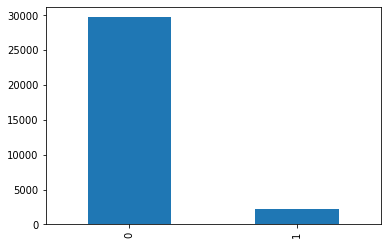

In [17]:
data_clean["label"].value_counts().sort_index().plot.bar()

In [18]:
data_clean["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [19]:
import random

def test_train_split(df, test_percent):
    X = []
    Y = []
    for i in range(len(df)):
        X.append(df["tweet"][i])
        Y.append(df["label"][i])
    C = list(zip(X,Y))
    random.shuffle(C)
    X,Y = zip(*C)
    split_idx = int(len(X)*test_percent)+1
    return list(X[split_idx:]),list(Y[split_idx:]),list(X[:split_idx]),list(Y[:split_idx])

In [20]:
X_train,Y_train,X_test,Y_test = test_train_split(data_clean,0.20)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [22]:
model = make_pipeline(TfidfVectorizer(),MultinomialNB())
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5936
           1       0.99      0.17      0.29       457

    accuracy                           0.94      6393
   macro avg       0.96      0.59      0.63      6393
weighted avg       0.94      0.94      0.92      6393



In [23]:
model = make_pipeline(TfidfVectorizer(),SVC())
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5936
           1       0.95      0.46      0.62       457

    accuracy                           0.96      6393
   macro avg       0.96      0.73      0.80      6393
weighted avg       0.96      0.96      0.95      6393



In [24]:
model = make_pipeline(TfidfVectorizer(),RandomForestClassifier())
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5936
           1       0.91      0.54      0.68       457

    accuracy                           0.96      6393
   macro avg       0.94      0.77      0.83      6393
weighted avg       0.96      0.96      0.96      6393



In [25]:
from sklearn.utils import resample

data_majority = data_clean[data_clean.label==0]
data_minority = data_clean[data_clean.label==1]

data_minority_upsampled = resample(data_minority, 
                                 replace=True,    
                                 n_samples=len(data_majority),   
                                 random_state=123)
data_upsampled = pd.concat([data_minority_upsampled, data_majority])
data_upsampled['label'].value_counts()                        

1    29720
0    29720
Name: label, dtype: int64

In [26]:
print(data_upsampled['tweet'].isna().sum())
print(data_upsampled['label'].isna().sum())
data_upsampled['tweet'] = data_upsampled['tweet'].apply(str)

0
0


In [27]:
print(data_upsampled.shape)
data_upsampled.head()

(59440, 2)


,label,tweet
19492,1,might libtard libtard sjw liberal politics
16151,1,good place sta learn abt one person amp bigot ...
25144,1,allahsoil bernanke bail wall street dump 600 b...
30902,1,wait somebody call dont see anybody
16522,1,white people expats rest us immigrants socialc...


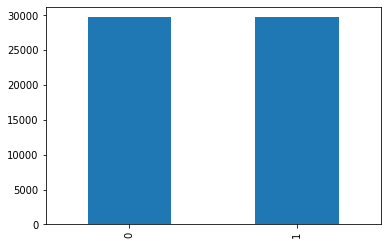

In [28]:
data_upsampled["label"].value_counts().sort_index().plot.bar()

In [32]:
from sklearn.model_selection import train_test_split

X_train_Up, X_test_Up, y_train_Up, y_test_Up = train_test_split(data_upsampled['tweet'], data_upsampled['label'],test_size=0.2, random_state = 0)

In [34]:
model = make_pipeline(TfidfVectorizer(),MultinomialNB())
model.fit(X_train_Up,y_train_Up)
Y_pred = model.predict(X_test_Up)

print(classification_report(y_test_Up, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      6007
           1       0.92      0.99      0.95      5881

    accuracy                           0.95     11888
   macro avg       0.95      0.95      0.95     11888
weighted avg       0.95      0.95      0.95     11888



In [35]:
model = make_pipeline(TfidfVectorizer(),SVC())
model.fit(X_train_Up,y_train_Up)
Y_pred = model.predict(X_test_Up)

print(classification_report(y_test_Up, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6007
           1       0.99      1.00      0.99      5881

    accuracy                           0.99     11888
   macro avg       0.99      1.00      0.99     11888
weighted avg       0.99      0.99      0.99     11888



In [36]:
model = make_pipeline(TfidfVectorizer(),RandomForestClassifier())
model.fit(X_train_Up,y_train_Up)
Y_pred = model.predict(X_test_Up)

print(classification_report(y_test_Up, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      6007
           1       0.97      1.00      0.99      5881

    accuracy                           0.99     11888
   macro avg       0.99      0.99      0.99     11888
weighted avg       0.99      0.99      0.99     11888



In [37]:
!pip install searchtweets

In [38]:
import yaml

config = dict(
    search_tweets_api=dict(
        account_type='premium',
        endpoint='https://api.twitter.com/1.1/tweets/search/fullarchive/dev.json',
        consumer_key='#########################',
        consumer_secret='##################################################',
        access_token='##################################################',
        access_token_secret='#############################################'
    )
)

with open('twitter_keys_full_archive.yaml', 'w') as config_file:
    yaml.dump(config, config_file, default_flow_style=False)

In [39]:
from searchtweets import load_credentials
premium_search_args = load_credentials("twitter_keys_full_archive.yaml",
                                       yaml_key="search_tweets_api",
                                       env_overwrite=False)
print(premium_search_args)

Grabbing bearer token from OAUTH


{'bearer_token': 'AAAAAAAAAAAAAAAAAAAAAHi0NgEAAAAAaQ8XEXwiQp0DwLLdd5MGEGZWpvE%3DaxDVIiCIZ26QEURSUU3CXIKbQMH5W5UktbI5OrMFuo4AsWtUXA', 'endpoint': 'https://api.twitter.com/1.1/tweets/search/fullarchive/dev.json', 'extra_headers_dict': None}


In [40]:
hashtag = input()

trump


In [41]:
hashtag1 = hashtag + " " + "lang:en"
from searchtweets import gen_rule_payload

rule = gen_rule_payload(hashtag1, results_per_call=100, from_date="2010-09-01", to_date="2020-10-30")
print(rule)

{"query": "trump lang:en", "maxResults": 100, "toDate": "202010300000", "fromDate": "201009010000"}


In [42]:
from searchtweets import ResultStream

rs = ResultStream(rule_payload=rule,
                  max_results=100,
                  **premium_search_args)

print(rs)

ResultStream: 
	{
    "username": null,
    "endpoint": "https://api.twitter.com/1.1/tweets/search/fullarchive/dev.json",
    "rule_payload": {
        "query": "trump lang:en",
        "maxResults": 100,
        "toDate": "202010300000",
        "fromDate": "201009010000"
    },
    "tweetify": true,
    "max_results": 100
}


In [43]:
tweets = list(rs.stream())

In [44]:
# [print(f"{tweet.all_text}\n\n") for tweet in tweets[0:100]];
i=1
for tweet in tweets[0:100]:
    print(f"{i}: {tweet.all_text}\n\n")
    i+=1


1: If Trump gets re-elected, he needs to shut all these media frauds out of the White House press room. They are Democratic shills and coverup artists masquerading as journalists. Clean out the stables and let a new group of genuine truth seekers take their place #FakeNewsMedia


2: Lil Wayne is voting for Trump AND he is a Green Bay Packer fan??  He may be the smartest person in the world!  #GoPackGo #MAGA https://t.co/5vuSFu8Wvh
if you don't like this, you're a racist. full stop. https://t.co/918R1AjW6z


3: @gollybass Drove through my neighbourhood yesterday and there was an old guy in a golf cart with two big-ass Trump flags. Honestly made me nauseous...


4: Trump and the Republicans are working very hard seemingly to make sure no one votes for Hillary Clinton or Hunter Biden in this election. In a spirit of bipartisanship I will not vote for either of them.


5: President @realDonaldTrump: The State of Israel and the Republic of Sudan have agreed to make peace. Full remarks: http

In [45]:
import csv

fields = ["tweet"]
temparray = []
for tweet in tweets[0:100]:
    temparray.append([tweet.all_text.encode("utf-8")])
    
filename = "tweetrecords.csv"

with open(filename, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(temparray)

In [74]:
real_world_data = pd.read_csv("/content/tweetrecords.csv")
real_world_data.head()

,tweet
0,"b'If Trump gets re-elected, he needs to shut a..."
1,"b""Lil Wayne is voting for Trump AND he is a Gr..."
2,b'@gollybass Drove through my neighbourhood ye...
3,b'Trump and the Republicans are working very h...
4,b'President @realDonaldTrump: The State of Isr...


In [77]:
real_world_data_clean = preprocessing(real_world_data, "tweet")
real_list = []
for i in range(len(real_world_data_clean)):
  real_world_data_clean["tweet"][i] = real_world_data_clean["tweet"][i][1:]
  real_list.append(real_world_data_clean["tweet"][i])

real_world_data_clean.head()

,tweet
0,if trump get reelect need shut media frauds wh...
1,lil wayne vote trump green bay packer fan may ...
2,drive neighbourhood yesterday old guy golf ca...
3,trump republicans work hard seemingly make sur...
4,president state israel republic sudan agree ma...


In [78]:
y_pred_real = model.predict(real_list)

In [79]:
print(y_pred_real)

[0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0]


In [81]:
for i in range(len(y_pred_real)):
  if y_pred_real[i] == 1:
    print(real_world_data["tweet"][i])
    print("\n")

lil wayne vote trump green bay packer fan may smartest person world gopackgo maga dont like youre racist full stop


president state israel republic sudan agree make peace full remark


trump amp biden tie texas nguys texas turn blue vote please vote


florida judge resign votecounting board follow report trump donations


all rappers endorse trump start pac call 2 pac


 daniel trump since hes office


lil wayne praise president xe2x81xa6xe2x81xa9xe2x80x99s platinum plan black americans listen assure get


we cant stress enough second trump term put adminsitrationxe2x80x99s authoritarian racist xenophobicagenda overdrive lot lose vote voteearly n


the majority people call president trump racist black unhinge white liberalsnnthink thatnnthey idea whatxe2x80x99s come


 black men know know con job see one know exactly trump mean repeatedly say save suburbs


opinion trump accidentally admit hexe2x80x99s abandon work women


 worry trump criminal cronies worry lockhimup


opinion alan a